# Final Exam

- Due Date: 04/27/2022,11:59pm
- Sajal Shrestha


In [15]:
# imports
import glob
import re
import datetime
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


## 1. Extract Phase: (12 Points)

Write an extract method that extracts the data from all the csv, json, and xml files. Append all the data
to a dataframe.


In [16]:
def extract_data(path):
    """Extracts data from given path

    Args:
        path (str): root directory where data files are stored

    Returns:
        pd.DataFrame: pandas Dataframe object with appended data
    """

    # main dataframe to append the data
    final_df = pd.DataFrame(
        columns=["car_model", "year_of_manufacture", "price", "fuel"]
    )

    for file in glob.glob(f"{path}/*.*"):

        # ignore if data is not in expected format
        if not re.search(r"\.(csv|json|xml)$", file):
            continue

        # extract file extension from file name
        file_extension = file.split(".")[-1]

        # get read function(read_csv, read_json, read_xml) dynamically from pd module
        read_func = getattr(pd, f"read_{file_extension}")

        # read data into data frame
        df = (
            read_func(file, lines=True)
            if file_extension == "json"
            else read_func(file)
        )

        # append to final data frame
        final_df = pd.concat([final_df, df])

    # return the extracted data
    return final_df


## 2. Transformation Phase: (12 points)

1. Change the car_model values to uppercase.
2. Round the car prices to two decimal digits (for example 10373.14).
3. Convert the Fuel column values to categorical values. That is, represent ‘Diesel’ with 1, ‘Petrol’
   with 2, and ‘CNG’ with 3.
4. Finally, add a new column called car_age. The values in this column should be difference between
   the current year (2022) and the manufacturing year of the car.
   <br> For instance, if the manufacturing_year is 2012, then the corresponding value in car_age should be 10 (2022 – 2012).


In [17]:
def get_current_year():
    """Get the current year

    Returns:
        int: current year
    """
    current_date = datetime.datetime.today()
    return current_date.year


def transform_data(df):
    """Perform data transformation

    Args:
        df (pd.DataFrame): pandas dataframe object

    Returns:
        pd.DataFrame: pandas dataframe object
    """
    # change car_model values to uppercase
    df["car_model"] = df["car_model"].str.upper()

    # round car prices to two decimal digit
    df["price"] = df["price"].map(lambda price: round(price, 2))

    # covert fuel to categorical values(Diesel -> 1, Petrol -> 2 and CNG -> 3)
    fuel_category = {"diesel": 1, "petrol": 2, "cng": 3}
    df["fuel"] = df["fuel"].map(lambda fuel: fuel_category[fuel.lower()])

    # add new column car_age.
    # The values in this column should be difference between the current year (2022)
    # and the manufacturing year of the car.
    current_year = get_current_year()
    df["car_age"] = df["year_of_manufacture"].apply(
        lambda year: current_year - year
    )

    return df


## 3. Load Phase: (3 points)

Load the data into a sqlite database table


In [18]:
def load_data(df, database, table):
    """Load data into sqlite table

    Args:
        df (pd.DataFrame): pandas dataframe object

    Returns:
        int: count of rows added
    """

    connection = sqlite3.connect(database)
    cursor = connection.cursor()

    # insert rows
    df.to_sql(table, con=connection, index=False, if_exists="replace")

    # get row count
    record_count = cursor.execute(f"SELECT count(*) FROM {table}").fetchone()[
        0
    ]

    # close connection
    connection.close()

    # return count of row inserted
    return record_count


## 4. Analysis and Plot Phase: (15 points)

1. Plot a graph where x-axis represents manufacturing-years and y-axis represents number of cars
   manufactured in those each years.
2. Draw an histogram that represents car-prices, and create appropriate buckets/bins (at-least five).
3. Using Pie chart plot the percentage of cars belonging to each fuel-type. For instance, there might
   be 20% diesel, 30% petrol, etc.


In [19]:
def plot_car_manufactured_by_year(axes, years, count):
    """Plots bar chart for car manufactured by year

    Args:
        axes (AxesSubplot): matplotlib axes
        years (list): list of years
        count (list): list of count of cars
    """
    # set figure size
    axes.bar(years, count, width=0.6)
    axes.set_xticks(years)
    axes.set_yticks(range(0, max(count) + 1))
    # set labels
    axes.set_xlabel("Year of Manufacture")
    axes.set_ylabel("Cars Manufactured")
    axes.set_title("Number of cars manufactured by year")


def plot_car_prices_distribution(axes, prices):
    """Plots histogram for car rpices

    Args:
        axes (AxesSubplot): matplotlib axes
        prices (list): list of car prices
    """

    # set figure size
    axes.hist(prices, bins=[0, 10000, 20000, 30000, 40000, 50000])

    # set labels
    axes.set_xlabel("Car Prices")
    axes.set_ylabel("Count")
    axes.set_title("Car Prices Distribution")


def plot_car_by_fuel_types(axes, percentage, labels):
    """Plot pie chart for car by fuel type

    Args:
        axes (AxesSubplot): matplotlib axes
        percentage (list): list of percentage of fuel types
        labels (list): labels for fuel types
    """
    axes.pie(
        percentage,
        labels=labels,
        autopct="%.2f%%",
        explode=[0.05 if max(percentage) == item else 0 for item in percentage],
    )
    # set labels
    axes.set_title("Percentage of cars by fuel type")


def analyse_data(database, table):
    """Analyse the dataset using plots

    Args:
        database (str): name of database
        table (str): table name
    """
    connection = sqlite3.connect(database)
    cursor = connection.cursor()
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # fetch data for number of cars manufactured by year
    cursor.execute(
        f"SELECT year_of_manufacture, COUNT(*) FROM {table} GROUP BY year_of_manufacture"
    )
    # prepare data
    data = {"years": [], "count": []}
    for item in cursor.fetchall():
        data["years"].append(item[0])
        data["count"].append(item[1])
    # plot
    plot_car_manufactured_by_year(axes=axes[0], **data)

    # fetch data for car prices distribution
    cursor.execute(f"SELECT price FROM {table}")
    # prepare data
    data = [item[0] for item in cursor]
    # plot
    plot_car_prices_distribution(axes=axes[1], prices=data)

    # fetch data for car by fuel type
    fuel_category = {1: "diesel", 2: "petrol", 3: "cng"}
    cursor.execute(f"SELECT fuel, count(*) FROM {table} GROUP BY fuel")
    # prepare data
    data = {fuel_category[item[0]].upper(): item[1] for item in cursor}
    # plot
    plot_car_by_fuel_types(
        axes=axes[2], percentage=list(data.values()), labels=list(data.keys())
    )

    fig.tight_layout()
    plt.show()


## 5. Log Phase: (3 points)

Write a log method to log the given message along with the date-time information. Invoke this method before and after each of the above phases.


In [20]:
def log(message):
    now = datetime.datetime.now()
    date_time = now.strftime("[%m/%d/%Y-%H:%M:%S]")
    print(date_time, message)

    log_timestamp = now.strftime("%m%d%Y")
    with open(f"log_{log_timestamp}.txt", "a") as log_file:
        log_file.write(date_time + " " + message + "\n")


log("Test Log")


[04/26/2022-14:20:04] Test Log


[04/26/2022-14:20:04] Extract Phase: Start
[04/26/2022-14:20:04] Data:
  car_model year_of_manufacture         price    fuel
0      ritz                2014        5000.0  Petrol
1       sx4                2013   7089.552239  Diesel
2      ciaz                2017  10820.895522  Petrol
3   wagon r                2011   4253.731343  Petrol
4     swift                2014   6865.671642  Diesel
[04/26/2022-14:20:04] Summary:
            car_model  year_of_manufacture        price    fuel
count              90                   90    90.000000      90
unique             25                   15    74.000000       3
top     corolla altis                 2015  7089.552239  Petrol
freq               11                   18     4.000000      52
[04/26/2022-14:20:04] Extract Phase: End
[04/26/2022-14:20:04] Transform Phase: Start
[04/26/2022-14:20:04] Data:
  car_model year_of_manufacture     price  fuel  car_age
0      RITZ                2014   5000.00     2        8
1       SX4               

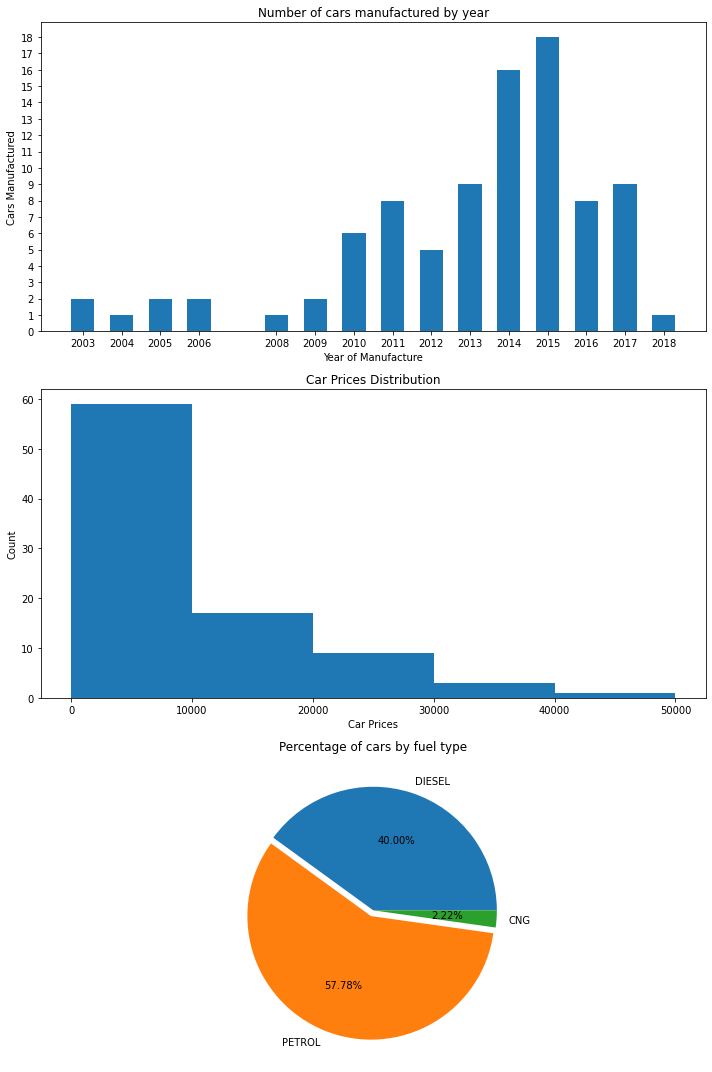

[04/26/2022-14:20:04] Analysis Phase: End


In [21]:
def main():
    database = "used_cars"
    table = "used_cars"

    # Extract Phase
    log("Extract Phase: Start")
    df = extract_data(path="UsedCarsData")
    log(f"Data:\n{df.head()}")
    log(f"Summary:\n{df.describe()}")
    log("Extract Phase: End")

    # Transform Phase
    log("Transform Phase: Start")
    df = transform_data(df)
    log(f"Data:\n{df.head()}")
    log("Transform Phase: End")

    # Load Phase
    log("Load Phase: Start")
    record_count = load_data(df, database, table)
    log(f"{record_count} records inserted")
    log("Load Phase: End")

    # Analysis Phase
    log("Analysis Phase: Start")
    analyse_data(database, table)
    log("Analysis Phase: End")

main()